## Pip Installs and Imports

In [72]:
pip install convokit

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [75]:
from convokit import Corpus, download
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import time

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import BernoulliNB
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/francescasalute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francescasalute/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francescasalute/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Explorative Data Anlyses

In [4]:
corpus = Corpus(filename=download("movie-corpus"))

In [5]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [6]:
utterances = corpus.get_utterances_dataframe() # text of the conversations

In [7]:
utterances.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L1045,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L1044,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L985,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L984,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
L925,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]


In [8]:
utterances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304713 entries, L1045 to L666256
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   timestamp        0 non-null       object
 1   text             304713 non-null  object
 2   speaker          304713 non-null  object
 3   reply_to         221616 non-null  object
 4   conversation_id  304713 non-null  object
 5   meta.movie_id    304713 non-null  object
 6   meta.parsed      304713 non-null  object
 7   vectors          304713 non-null  object
dtypes: object(8)
memory usage: 20.9+ MB


In [9]:
conversations = corpus.get_conversations_dataframe() # movie genres linked to conversations

In [10]:
conversations.head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


In [11]:
conversations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83097 entries, L1044 to L666256
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   vectors            83097 non-null  object
 1   meta.movie_idx     83097 non-null  object
 2   meta.movie_name    83097 non-null  object
 3   meta.release_year  83097 non-null  object
 4   meta.rating        83097 non-null  object
 5   meta.votes         83097 non-null  object
 6   meta.genre         83097 non-null  object
dtypes: object(7)
memory usage: 5.1+ MB


In [12]:
conversations.describe()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
count,83097,83097,83097,83097,83097,83097,83097
unique,1,617,617,88,62,614,290
top,[],m289,casino,1999,7.20,111223,['drama']
freq,83097,338,338,6646,3694,338,5027


In [13]:
characters = corpus.get_speakers_dataframe() # name and gender of speaker 

In [14]:
characters.head()

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u0,[],BIANCA,m0,10 things i hate about you,f,4
u2,[],CAMERON,m0,10 things i hate about you,m,3
u3,[],CHASTITY,m0,10 things i hate about you,?,?
u4,[],JOEY,m0,10 things i hate about you,m,6
u5,[],KAT,m0,10 things i hate about you,f,2


In [15]:
characters['meta.gender'].value_counts()

?    6020
m    1899
f     921
M     150
F      45
Name: meta.gender, dtype: int64

In [16]:
# Clean the gender column
characters['meta.gender'] = characters['meta.gender'].str.lower()
characters['meta.gender'].value_counts()

?    6020
m    2049
f     966
Name: meta.gender, dtype: int64

In [17]:
print(characters['meta.gender'].unique())

['f' 'm' '?']


In [18]:
# Drop the ? value
rows_to_drop = characters[characters['meta.gender'] == '?'].index
characters = characters.drop(rows_to_drop)
characters['meta.gender'].value_counts()

m    2049
f     966
Name: meta.gender, dtype: int64

## Merge the Dataframes

In [19]:
# Merge the DataFrames on 'conversation_id' from utterances and 'id' from conversations
merged_df = pd.merge(utterances, conversations, left_on='conversation_id', right_on='id', suffixes=('_utterance', '_conversation'))
merged_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors_utterance,vectors_conversation,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
0,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
1,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
2,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[],[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
3,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[],[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
4,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[],[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


In [20]:
# # Merge the DataFrames on 'speaker' from merged and 'id' from character
final_df = pd.merge(merged_df, characters, left_on='speaker', right_on='id', how='left', suffixes=('_merged', '_character'))
final_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors_utterance,vectors_conversation,meta.movie_idx_merged,...,meta.release_year,meta.rating,meta.votes,meta.genre,vectors,meta.character_name,meta.movie_idx_character,meta.movie_name_character,meta.gender,meta.credit_pos
0,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,...,1999,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4
1,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,...,1999,6.90,62847,"['comedy', 'romance']",[],CAMERON,m0,10 things i hate about you,m,3
2,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[],[],m0,...,1999,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4
3,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[],[],m0,...,1999,6.90,62847,"['comedy', 'romance']",[],CAMERON,m0,10 things i hate about you,m,3
4,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[],[],m0,...,1999,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4


In [21]:
final_df['speaker'].value_counts() # how many times we see every speaker intervenes

u4525    537
u1169    489
u1475    472
u3681    467
u4331    465
        ... 
u7566      3
u7562      3
u8483      3
u1840      3
u8011      3
Name: speaker, Length: 9035, dtype: int64

In [22]:
# Add a column with the number of line each character has
final_df['line_count'] = final_df.groupby('speaker')['speaker'].transform('size')
final_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors_utterance,vectors_conversation,meta.movie_idx_merged,...,meta.rating,meta.votes,meta.genre,vectors,meta.character_name,meta.movie_idx_character,meta.movie_name_character,meta.gender,meta.credit_pos,line_count
0,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,...,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4,98
1,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,...,6.90,62847,"['comedy', 'romance']",[],CAMERON,m0,10 things i hate about you,m,3,78
2,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[],[],m0,...,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4,98
3,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[],[],m0,...,6.90,62847,"['comedy', 'romance']",[],CAMERON,m0,10 things i hate about you,m,3,78
4,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[],[],m0,...,6.90,62847,"['comedy', 'romance']",[],BIANCA,m0,10 things i hate about you,f,4,98


In [25]:
final_df.shape

(304713, 22)

In [24]:
# Check all null values
print(final_df.isnull().sum())

timestamp                    304713
text                              0
speaker                           0
reply_to                      83097
conversation_id                   0
meta.movie_id                     0
meta.parsed                       0
vectors_utterance                 0
vectors_conversation              0
meta.movie_idx_merged             0
meta.movie_name_merged            0
meta.release_year                 0
meta.rating                       0
meta.votes                        0
meta.genre                        0
vectors                       62690
meta.character_name           62690
meta.movie_idx_character      62690
meta.movie_name_character     62690
meta.gender                   62690
meta.credit_pos               62690
line_count                        0
dtype: int64


In [26]:
# Drop null values in gender after the mergin of datasets
final_df = final_df.dropna(subset=['meta.gender'])
final_df['meta.gender'].isnull().sum()

0

In [27]:
final_df['meta.gender'].value_counts()

m    170768
f     71255
Name: meta.gender, dtype: int64

In [29]:
final_df = final_df.drop(columns=['timestamp'])
final_df = final_df.drop(columns=['reply_to'])
print(final_df.isnull().sum()) # no null values present

KeyError: "['timestamp'] not found in axis"

In [37]:
# Credit column
final_df['meta.credit_pos'].value_counts()

1      79624
2      46521
10+    42853
3      26075
4      15423
5      10518
6       8533
8       4726
7       4675
9       3075
Name: meta.credit_pos, dtype: int64

In [38]:
# Aggregate all the Credit that are 10 or more
final_df['meta.credit_pos'] = final_df['meta.credit_pos'].apply(lambda p: '10+' if not p in ['1', '2', '3', '4', '5', '6', '7', '8', '9'] else p)  ## Label encoding
final_df['meta.credit_pos'].value_counts()

1      79624
2      46521
10+    42853
3      26075
4      15423
5      10518
6       8533
8       4726
7       4675
9       3075
Name: meta.credit_pos, dtype: int64

In [39]:
# Create two columns with the lenght of each line by characters and by words
final_df['lineLength'] = final_df['text'].str.len()             # length of each line by characters
final_df['wordCountLine'] = final_df['text'].str.count(' ') + 1 # length of each line by words
final_df.head()

,text,speaker,conversation_id,meta.movie_id,meta.parsed,vectors_utterance,vectors_conversation,meta.movie_idx_merged,meta.movie_name_merged,meta.release_year,...,meta.character_name,meta.movie_idx_character,meta.movie_name_character,meta.gender,meta.credit_pos,line_count,lineLength,wordCountLine,medianLineLength,medianWordCountLine
0,They do not!,u0,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,...,BIANCA,m0,10 things i hate about you,f,4,98,12,3,36.0,7.5
1,They do to!,u2,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,...,CAMERON,m0,10 things i hate about you,m,3,78,11,3,29.5,6.0
2,I hope so.,u0,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[],[],m0,10 things i hate about you,1999,...,BIANCA,m0,10 things i hate about you,f,4,98,10,3,36.0,7.5
3,She okay?,u2,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[],[],m0,10 things i hate about you,1999,...,CAMERON,m0,10 things i hate about you,m,3,78,9,2,29.5,6.0
4,Let's go.,u0,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[],[],m0,10 things i hate about you,1999,...,BIANCA,m0,10 things i hate about you,f,4,98,9,2,36.0,7.5


In [40]:
# Calculate the median of the line lengths for each speaker
final_df['medianLineLength'] = final_df.groupby('speaker')['lineLength'].transform('median')

# Calculate the median word count for each speaker
final_df['medianWordCountLine'] = final_df.groupby('speaker')['wordCountLine'].transform('median')

In [53]:
# Making sure all columns are in the correct type
final_df['meta.rating'] = pd.to_numeric(final_df['meta.rating'], errors='coerce')
final_df['meta.votes'] = pd.to_numeric(final_df['meta.votes'], errors='coerce')
final_df['meta.release_year'] = pd.to_numeric(final_df['meta.release_year'], errors='coerce').astype('Int64')

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142023 entries, 249012 to 304627
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   text                       142023 non-null  object 
 1   speaker                    142023 non-null  object 
 2   conversation_id            142023 non-null  object 
 3   meta.movie_id              142023 non-null  object 
 4   meta.parsed                142023 non-null  object 
 5   vectors_utterance          142023 non-null  object 
 6   vectors_conversation       142023 non-null  object 
 7   meta.movie_idx_merged      142023 non-null  object 
 8   meta.movie_name_merged     142023 non-null  object 
 9   meta.release_year          138771 non-null  Int64  
 10  meta.rating                142023 non-null  float64
 11  meta.votes                 142023 non-null  int64  
 12  meta.genre                 142023 non-null  object 
 13  vectors                 

## Correct the imbalance 

In [54]:
final_df.shape

(142023, 24)

In [55]:
# Filter rows with 'meta.gender' equal to 'm'
m_rows = final_df[final_df['meta.gender'] == 'm']

# Filter rows with 'meta.gender' different from 'm'
non_m_rows = final_df[final_df['meta.gender'] != 'm']

# Randomize and remove 100,000 rows from subset with 'm'
m_rows_sampled = m_rows.sample(n=70768, random_state=42)

# Combine the remaining subsets
final_df = pd.concat([m_rows_sampled, non_m_rows])

In [56]:
final_df.shape

(142023, 24)

In [57]:
# Now male and female speakers number is more or less equal, compared with before where a huge gap would cause a biased analysis
final_df['meta.gender'].value_counts()

f    71255
m    70768
Name: meta.gender, dtype: int64

## Visualizations of the Data

  meta.gender  total_lines  avg_word_count
0           f      9276513       10.269581
1           m     11086171       10.995591


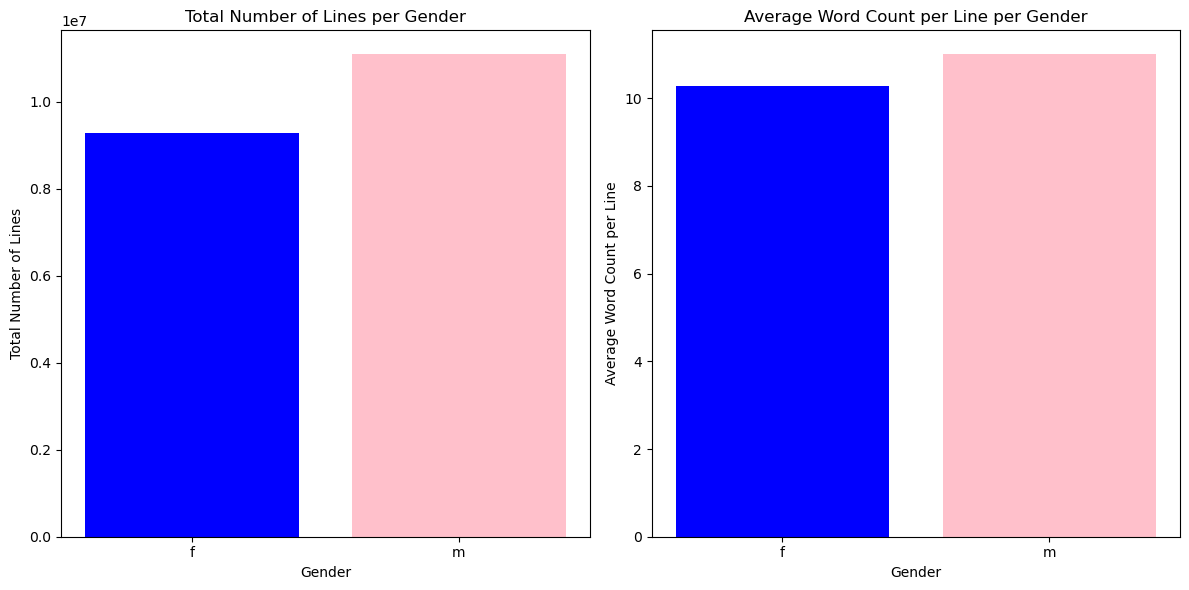

In [58]:
# Calculate the total number of lines and the average word count per line for each gender
gender_stats = final_df.groupby('meta.gender').agg(
    total_lines=('line_count', 'sum'),
    avg_word_count=('wordCountLine', 'mean')
).reset_index()

# Show statistics per gender
print(gender_stats)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the total number of lines per gender
axes[0].bar(gender_stats['meta.gender'], gender_stats['total_lines'], color=['blue', 'pink'])
axes[0].set_title('Total Number of Lines per Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Total Number of Lines')

# Plot the average word count per line per gender
axes[1].bar(gender_stats['meta.gender'], gender_stats['avg_word_count'], color=['blue', 'pink'])
axes[1].set_title('Average Word Count per Line per Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Average Word Count per Line')

# Show the plots
plt.tight_layout()
plt.show()

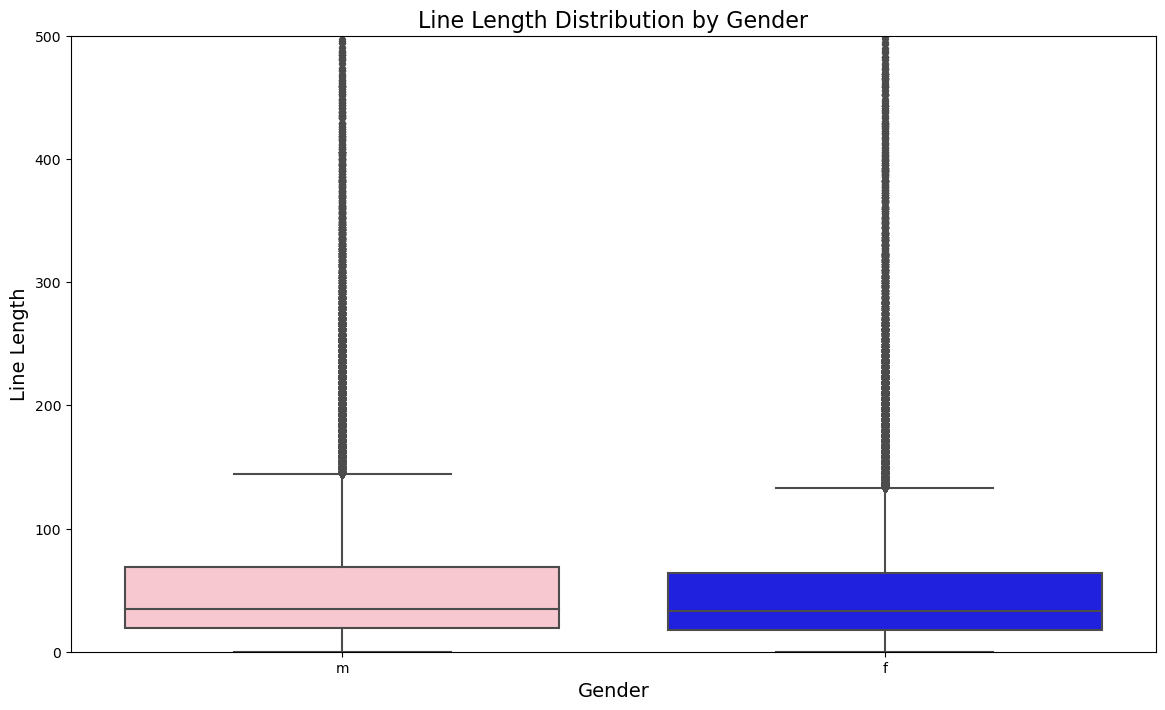

In [73]:
# Line Lenght Distribution by Gender
plt.figure(figsize=(14, 8))
sns.boxplot(x='meta.gender', y='lineLength', data=final_df, palette={"m": "pink", "f": "blue"})
plt.title('Line Length Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Line Length', fontsize=14)
plt.ylim(0, 500)  
plt.show()

meta.gender          f      m
meta.credit_pos              
1                13367  27592
10+              12891  12219
2                22598   9911
3                 8745   7164
4                 5203   4251
5                 2401   3426
6                 2295   2528
7                 1288   1426
8                 1321   1432
9                 1146    819


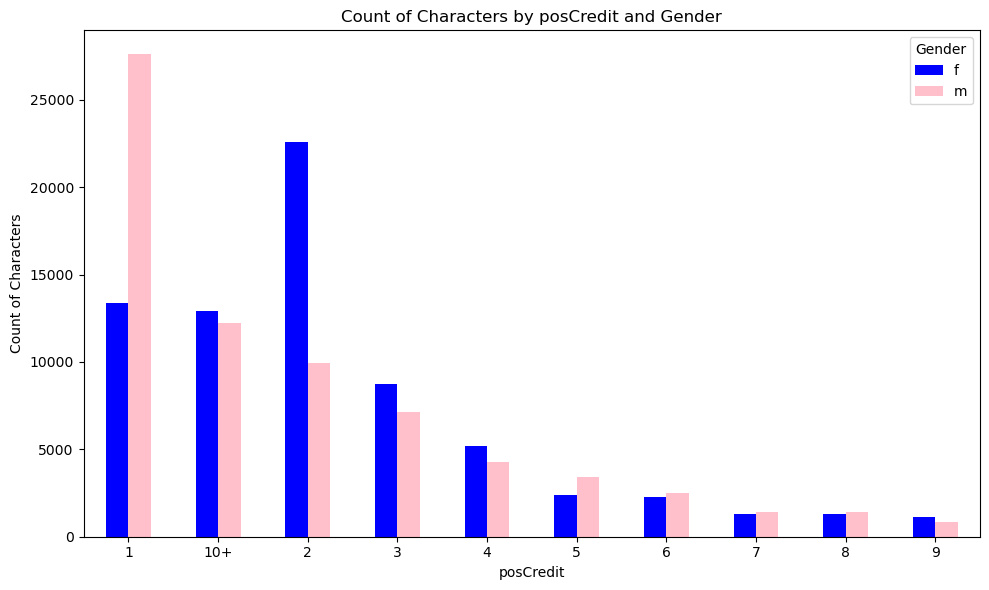

In [59]:
# Calculate the number of characters per posCredit and gender
posCredit_gender_counts = final_df.groupby(['meta.credit_pos', 'meta.gender']).size().unstack(fill_value=0)

# Show the count per Credit and gender
print(posCredit_gender_counts)

# Plot the data
posCredit_gender_counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'pink'])
plt.title('Count of Characters by posCredit and Gender')
plt.xlabel('posCredit')
plt.ylabel('Count of Characters')
plt.legend(title='Gender')
plt.xticks(rotation=0)  # Mantiene le etichette sull'asse x orizzontali
plt.tight_layout()
plt.show()

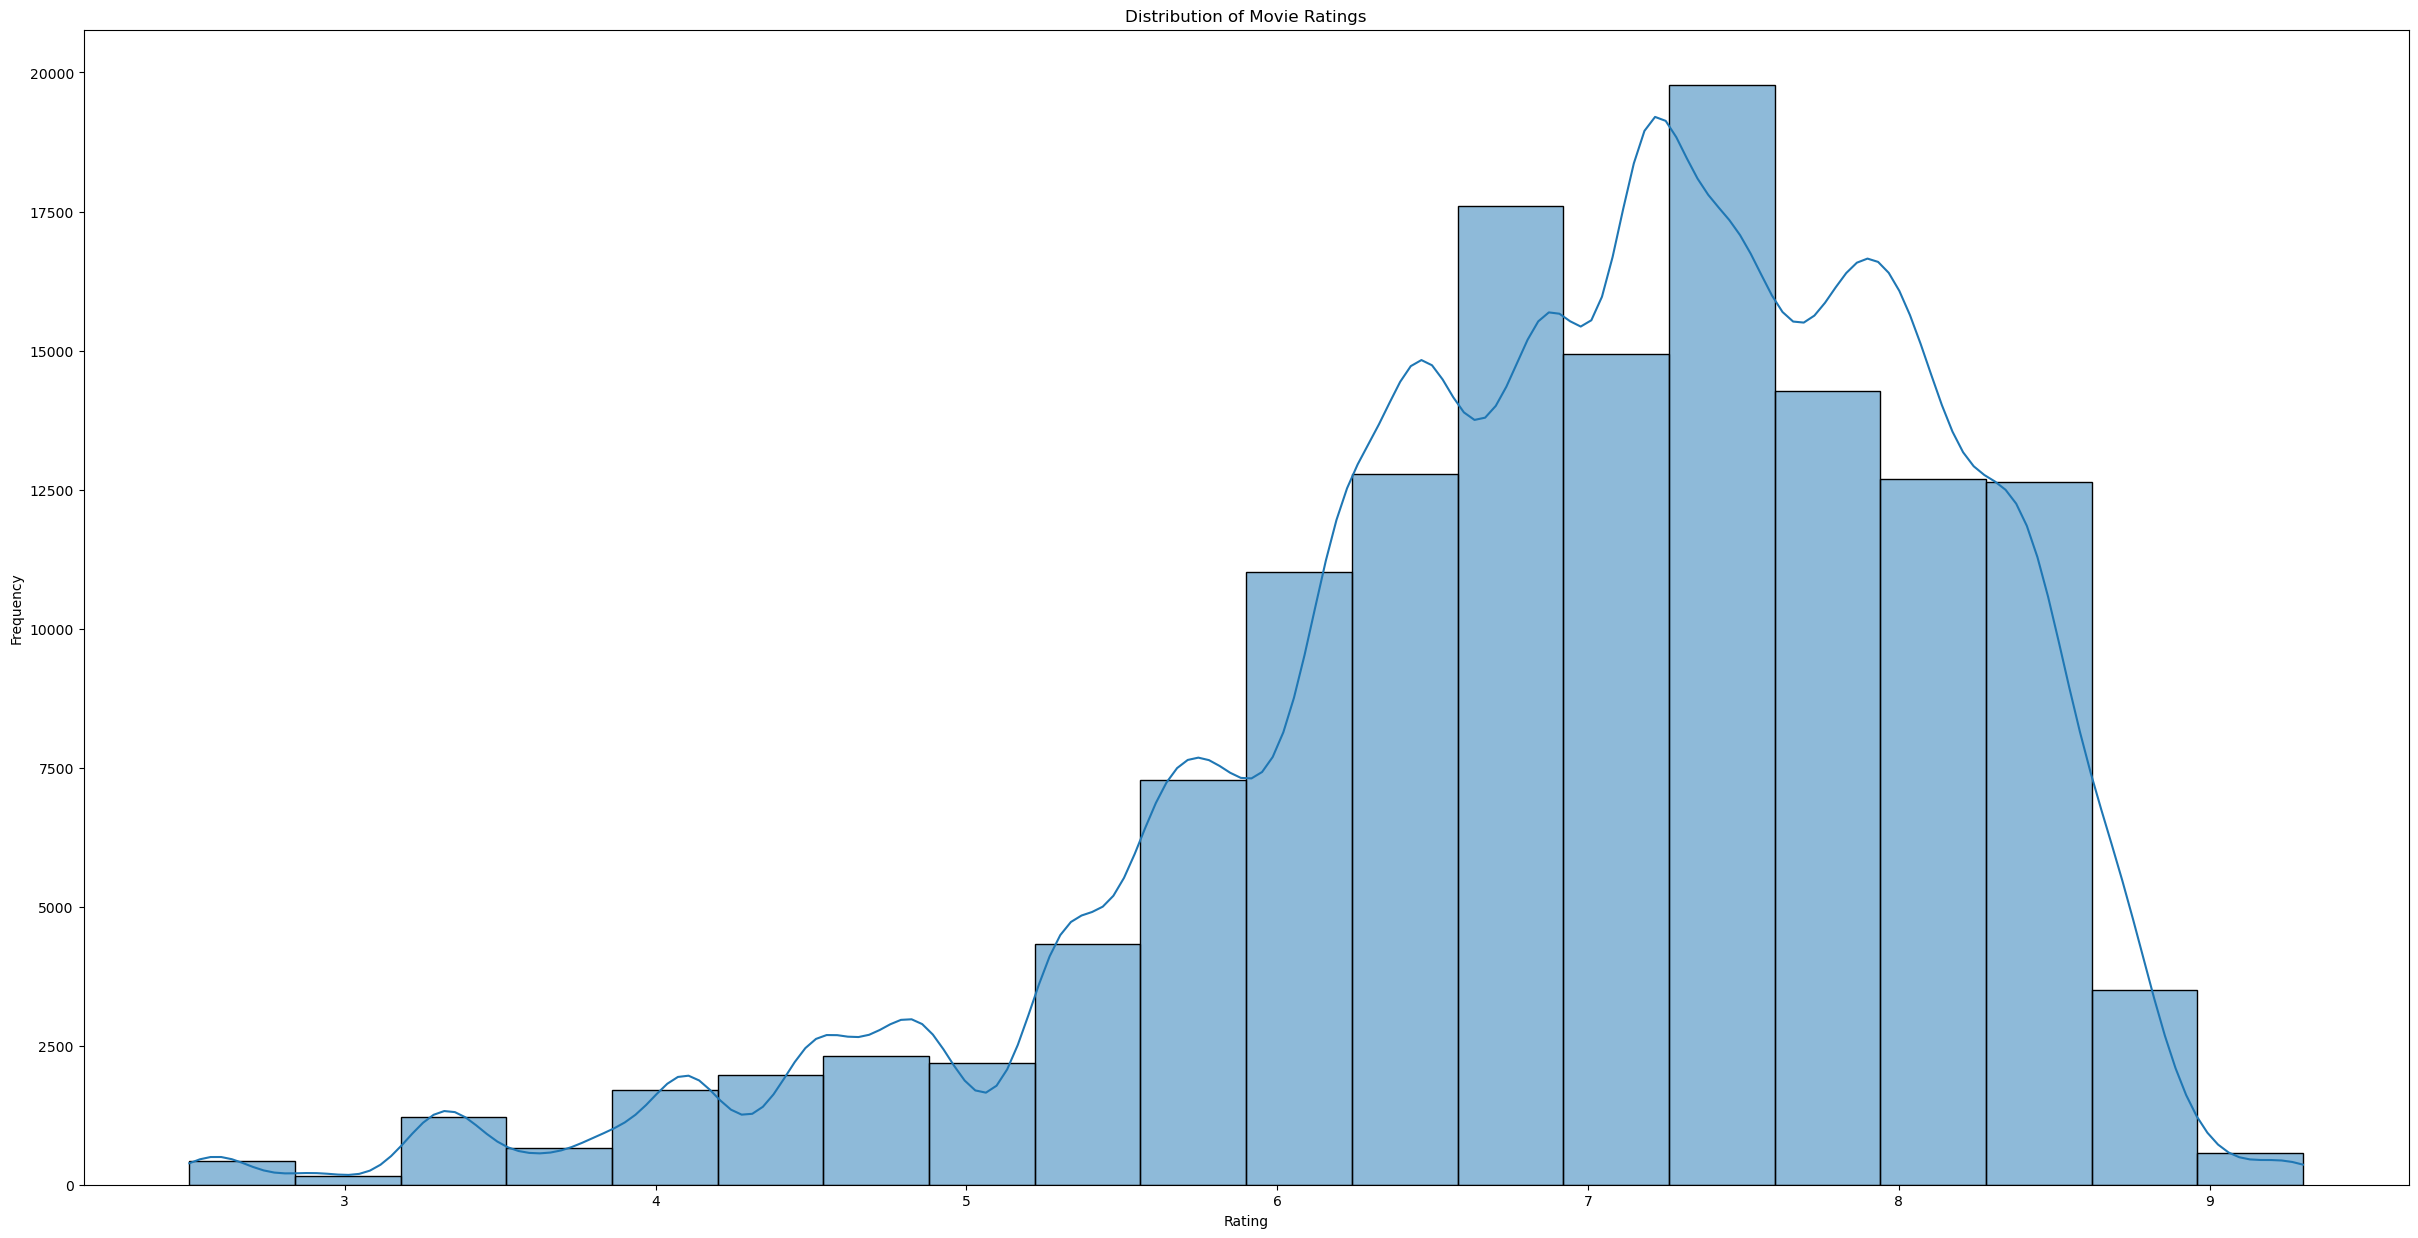

In [48]:
# Ratings Distribution 
plt.figure(figsize=(30, 15))
sns.histplot(final_df['meta.rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

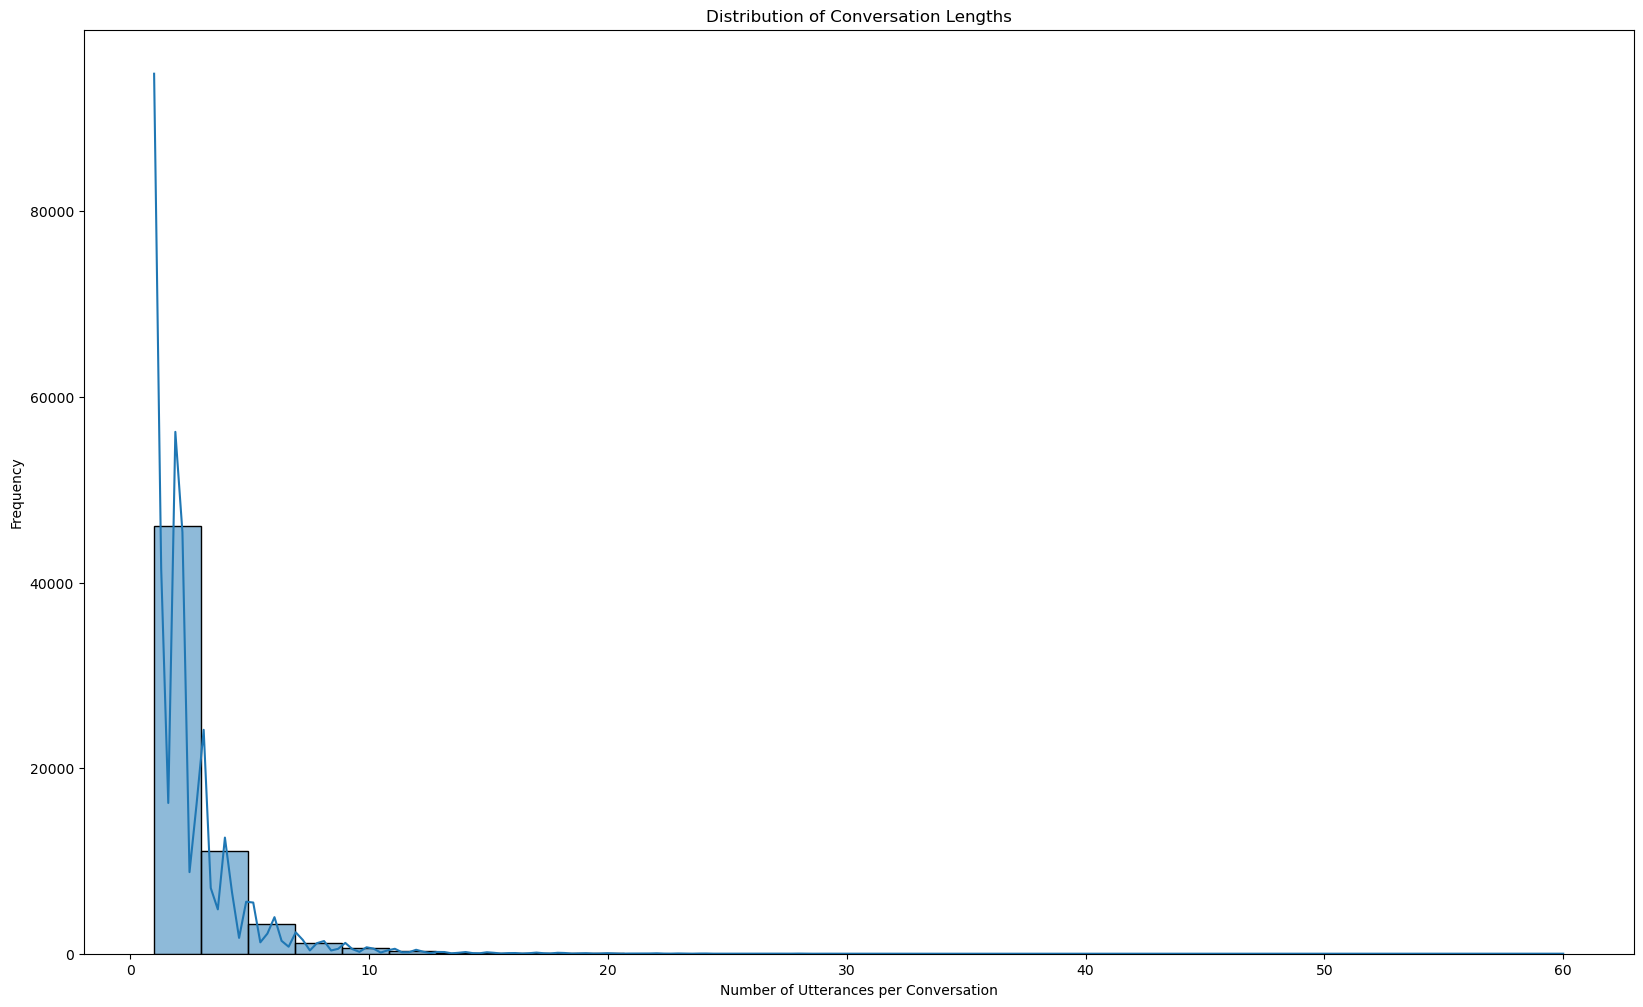

In [49]:
# Conversations lenghts
conversation_lengths = final_df['conversation_id'].value_counts()

plt.figure(figsize=(20, 12))
sns.histplot(conversation_lengths, bins=30, kde=True)
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Utterances per Conversation')
plt.ylabel('Frequency')
plt.show()


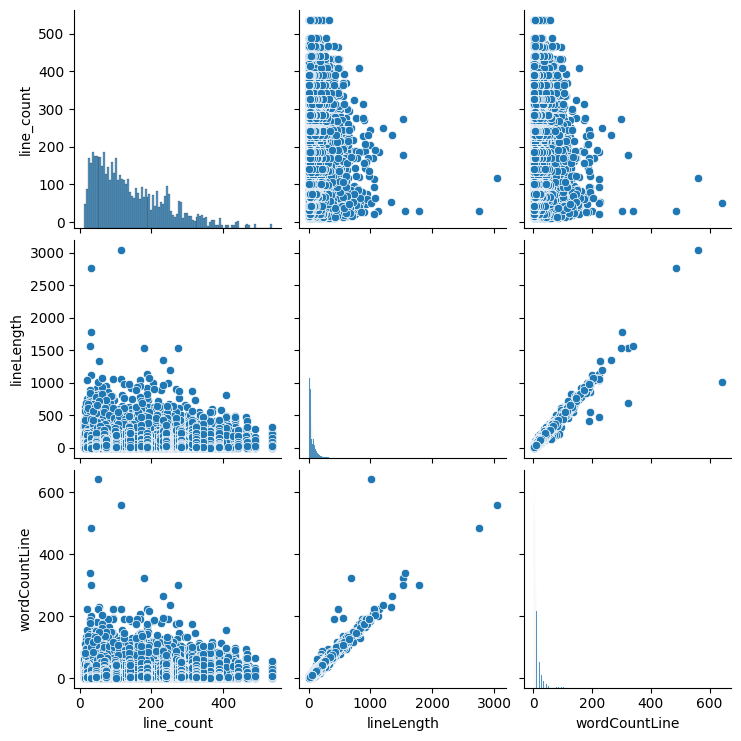

In [63]:
# Pairplot about lines features
sns.pairplot(final_df[['line_count', 'lineLength',	'wordCountLine']])
plt.show()

In [65]:
# Create Labelcoder
label_encoder = LabelEncoder()

# Applied to meta.gender
final_df['gender_encoded'] = label_encoder.fit_transform(final_df['meta.gender'])

category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(category_mapping)

{'f': 0, 'm': 1}


## Pre-processing

In [66]:
# Extend stopwords list
stop_words = set(stopwords.words('english'))
stop_words.update([',', '.', '?', ':', ';', "'", '“', '”', '!', '’', '...', '....', '--', '_'])

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [67]:
# Apply preprocessing
final_df['processed_text'] = final_df['text'].apply(preprocess_text)

## Pre - Models

Vectorization

In [68]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) 
X_text = vectorizer.fit_transform(final_df['processed_text'])

Encoding

In [69]:
# Encoding the labels
le = LabelEncoder()
final_df['gender_label'] = le.fit_transform(final_df['meta.gender'])
y = final_df['gender_label']

In [70]:
# Apply LabelEncoder to meta.credit_pos
credit_pos_encoder = LabelEncoder()
final_df['encoded_credit_pos'] = credit_pos_encoder.fit_transform(final_df['meta.credit_pos'])

Train the Model

In [55]:
# Combine the text features with the other features
X_other = final_df[['line_count', 'encoded_credit_pos', 'medianLineLength', 'medianWordCountLine']]

# Convert X_other to a sparse matrix and combine with X_text
X_other_sparse = csr_matrix(X_other.values)
X_combined = hstack([X_text, X_other_sparse])

In [56]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Naive Bayers

In [57]:
# Start the timer for the entire process
start_time = time.time()
# Initialize the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB()
# Train the classifier
nb_clf.fit(X_train, y_train)

# Make predictions on the test set
nb_y_pred = nb_clf.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, nb_y_pred)
report = classification_report(y_test, nb_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           f       0.54      0.58      0.56     14280
           m       0.55      0.51      0.52     14125

    accuracy                           0.54     28405
   macro avg       0.54      0.54      0.54     28405
weighted avg       0.54      0.54      0.54     28405

Total Execution Time: 0.06267285346984863 seconds


In [ ]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) 
X_text_1 = vectorizer.fit_transform(final_df['processed_text'])

# Binarizzazione dei dati TF-IDF
binarizer = Binarizer()
X_binary = binarizer.fit_transform(X_text_1.toarray())

In [ ]:
# Combine the text features with the other features
X_other_1 = final_df[['line_count', 'encoded_credit_pos', 'medianLineLength', 'medianWordCountLine']]

# Convert X_other to a sparse matrix and combine with X_text
X_other_sparse_1 = csr_matrix(X_other_1.values)
X_combined_1 = hstack([X_text_1, X_other_sparse_1])

# Split the data into 80% training and 20% testing sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_combined_1, y, test_size=0.2, random_state=42)

In [ ]:
# Start the timer for the entire process
start_time = time.time()

# Inizializzazione del Bernoulli Naive Bayes
bnb = BernoulliNB()

# Addestramento del modello
bnb.fit(X_train_1, y_train_1)

# Predizione
y_pred = bnb.predict(X_test_1)

# Valutazione del modello
accuracy = accuracy_score(y_test_1, y_pred)
report = classification_report(y_test_1, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

## Logistic Regression

In [58]:
# On full dataset
# Start the timer for the entire process
start_time = time.time()

# Logistic Regression classifier
lr_clr = LogisticRegression(solver = 'lbfgs', n_jobs=-1) 
lr_clr.fit(X_train, y_train)

# Predictions
lr_y_pred = lr_clr.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, lr_y_pred)
report = classification_report(y_test, lr_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           f       0.60      0.59      0.60     14280
           m       0.60      0.61      0.60     14125

    accuracy                           0.60     28405
   macro avg       0.60      0.60      0.60     28405
weighted avg       0.60      0.60      0.60     28405

Total Execution Time: 3.9223568439483643 seconds


## SVM

In [59]:
'''
I haven't run this yet, might take too long

# svm model Johanna
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

# Predictions
svm_y_pred = svm.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)'''

'\nI haven\'t run this yet, might take too long\n\n# svm model Johanna\nfrom sklearn.svm import SVC\nsvm = SVC(kernel=\'linear\', C=1, random_state=42)\nsvm.fit(X_train, y_train)\n\n# Predictions\nsvm_y_pred = svm.predict(X_test)\n\n# Calculate accuracy, precision, recall, and F1-score of the model\naccuracy = accuracy_score(y_test, y_pred)\nreport = classification_report(y_test, y_pred, target_names=le.classes_)\n\nprint(f"Accuracy: {accuracy:.2f}")\nprint("Classification Report:\n", report)'

In [60]:
# Take a 1% sample of the dataset
sample_size = 0.20
df_sample = final_df.sample(frac=sample_size, random_state=42)

# Recreate the combined features for the sample
X_text_sample = vectorizer.transform(df_sample['processed_text'])
X_other_sample = df_sample[['line_count', 'medianWordCountLine', 'encoded_credit_pos', 'medianLineLength']]
X_other_sparse_sample = csr_matrix(X_other_sample.values)
X_combined_sample = hstack([X_text_sample, X_other_sparse_sample])
y_sample = df_sample['gender_label']

# Split the sample into 80% training and 20% testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_combined_sample, y_sample, test_size=0.2, random_state=42)

In [61]:
# SVM with PCA 50 components -- SAMPLE

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Start the timer for the entire process
start_time = time.time()

# Define the PCA and SVM pipeline
pca = PCA(n_components=50)  # Preserve 95% of variance
svm = SVC(kernel='rbf', random_state=42)
pipeline = Pipeline([('pca', pca), ('svm', svm)])

# Define the parameter grid for GridSearch
param_grid = {'svm__C': [0.1, 1, 10, 100, 1000]}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV with parallelism
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)
execution_time = time.time() - start_time

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
svm_y_pred = best_svm.predict(X_test_sample)

# Evaluate the model
accuracy = accuracy_score(y_test_sample, svm_y_pred)
report = classification_report(y_test_sample, svm_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py", line 454, in fit_transform
    U, S, Vt = self._fit(X)
               ^^^^^^^^^^^^
  File "C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_pca.py", line 472, in _fit
    raise TypeError(
TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.


In [ ]:
'''# SVM without PCA with linear

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import time

# Start the timer for the entire process
start_time = time.time()

# Define the SVM model
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state=42)

# Define the parameter grid for GridSearch
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# GridSearchCV with parallelism
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
svm_y_pred = best_svm.predict(X_test_sample)

# Evaluate the model
accuracy = accuracy_score(y_test_sample, svm_y_pred)
report = classification_report(y_test_sample, svm_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")'''

'# SVM without PCA with linear\n\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.svm import SVC\nimport time\n\n# Start the timer for the entire process\nstart_time = time.time()\n\n# Define the SVM model\nfrom sklearn.svm import SVC\nsvm = SVC(kernel=\'linear\', random_state=42)\n\n# Define the parameter grid for GridSearch\nparam_grid = {\'C\': [0.1, 1, 10, 100, 1000]}\n\n# GridSearchCV with parallelism\ngrid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)\ngrid_search.fit(X_train_sample, y_train_sample)\n\n# Best estimator\nbest_svm = grid_search.best_estimator_\n\n# Predictions\nsvm_y_pred = best_svm.predict(X_test_sample)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test_sample, svm_y_pred)\nreport = classification_report(y_test_sample, svm_y_pred, target_names=le.classes_)\n\nprint(f"Accuracy: {accuracy:.2f}")\nprint("Classification Report:\n", report)\n\n# End the timer for the entire process\nend_time = time.time()\n\n# Calculat

In [ ]:
# SVM without PCA with rbg -- SAMPLE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import time

# Start the timer for the entire process
start_time = time.time()

# Define the SVM model
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=42)

# Define the parameter grid for GridSearch
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# GridSearchCV with parallelism
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

# Best estimator
best_svm = grid_search.best_estimator_

# Predictions
svm_y_pred = best_svm.predict(X_test_sample)

# Evaluate the model
accuracy = accuracy_score(y_test_sample, svm_y_pred)
report = classification_report(y_test_sample, svm_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           f       0.62      0.72      0.67      2848
           m       0.67      0.57      0.61      2833

    accuracy                           0.64      5681
   macro avg       0.64      0.64      0.64      5681
weighted avg       0.64      0.64      0.64      5681

Total Execution Time: 101.348459482193 seconds


# Random Forest 

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Start the timer for the entire process
start_time = time.time()

# Random Forest with all CPUs
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
rf_y_pred = rf.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, rf_y_pred)
report = classification_report(y_test, rf_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           f       0.91      0.94      0.92     14280
           m       0.94      0.90      0.92     14125

    accuracy                           0.92     28405
   macro avg       0.92      0.92      0.92     28405
weighted avg       0.92      0.92      0.92     28405

Total Execution Time: 10.954237222671509 seconds


# MLP CLassifier

In [ ]:
# Take a 20% sample of the dataset
sample_size = 0.20
df_sample = final_df.sample(frac=sample_size, random_state=42)

# Recreate the combined features for the sample
X_text_sample = vectorizer.transform(df_sample['processed_text'])
X_other_sample = df_sample[['line_count', 'medianWordCountLine', 'encoded_credit_pos', 'medianLineLength']]
X_other_sparse_sample = csr_matrix(X_other_sample.values)
X_combined_sample = hstack([X_text_sample, X_other_sparse_sample])
y_sample = df_sample['gender_label']

# Split the sample into 80% training and 20% testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_combined_sample, y_sample, test_size=0.2, random_state=42)

In [ ]:
# MLP Classifier
from sklearn.neural_network import MLPClassifier
from joblib import parallel_backend

# Start the timer for the entire process
start_time = time.time()

# MLP Classifier with parallel backend
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Use joblib to parallelize the fit method
with parallel_backend('threading', n_jobs=-1):
    mlp.fit(X_train_sample, y_train_sample)

# Predictions
mlp_y_pred = mlp.predict(X_test_sample)


# Evaluate the model
accuracy = accuracy_score(y_test_sample, mlp_y_pred)
report = classification_report(y_test_sample, mlp_y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

           f       0.62      0.58      0.60      2848
           m       0.60      0.64      0.62      2833

    accuracy                           0.61      5681
   macro avg       0.61      0.61      0.61      5681
weighted avg       0.61      0.61      0.61      5681

Total Execution Time: 348.8934259414673 seconds


In [ ]:
'''
I haven't run this yet, It will take a lot :(

# MLP Classifier
from sklearn.neural_network import MLPClassifier
from joblib import parallel_backend

# MLP Classifier with parallel backend
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Use joblib to parallelize the fit method
with parallel_backend('threading', n_jobs=-1):
    mlp.fit(X_train, y_train)

# Predictions
mlp_y_pred = mlp.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, mlp_y_pred)
precision = precision_score(y_test, mlp_y_pred, average='weighted')
recall = recall_score(y_test, mlp_y_pred, average='weighted')
f1 = f1_score(y_test, mlp_y_pred, average='weighted')
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")'''